In [12]:
from train.training_session_v1 import load_training_session
import multiprocessing
import torch

device = "cuda"

session = load_training_session(
    save_path="saves/phase2/architecture/task/transformers/4C4Con_d256/epoch_39",
    studies={"gwilliams2023": "audio"},
    data_path="/home/ubuntu/storage-texas/data",
    cache_name="cache",
)

dataloader = session.get_dataloader(buffer_size=1, num_workers=1, max_cache_size=100)

# Unseen both
# recording = session.studies["gwilliams2023"].recordings[19][0][0]

# Seen
# recording = session.studies["gwilliams2023"].recordings[15][0][1]

# Unseen task
# recording = session.studies["gwilliams2023"].recordings[18][0][0]

# Unseen subject
recording = session.studies["gwilliams2023"].recordings[19][0][1]

print(
    f"Showing recording: {recording.study_name}_{recording.subject_id}_{recording.task_id}"
)

dataloader.start_fetching(recordings=[recording])
batch = dataloader.get_recording()
brain, audio, recording = (
    batch.brain_segments["all"].to(device),
    batch.audio_segments.to(device),
    batch.recording,
)

conditions = {
    "study": f"{recording.study_name}",
    "subject": f"{recording.study_name}_{recording.subject_id}",
}
session.model.to(device).eval()

with torch.no_grad():
    (
        x,  # [B, C, T]
        quantizer_metrics,
        channel_weights,
        hidden_outputs,
        encoder_hidden_states,  # L * [B, T, D]
    ) = session.model(
        x=[brain],
        recording=[recording],
        conditions=[conditions],
        mel=[audio],
        train=False,
        return_hidden_outputs=False,
    )

dataloader.stop()

Loading Gwilliams2023 with batch type audio


Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 45, Unseen Subject: 12, Unseen Both: 4.

RNNEncoder initialized as conformer with 4 layers, 256 d_model, 4 nhead
	Embedding: sinusoidal, params: 6075392
SimpleConv initialized with 8927984 parameters, cond: ['study', 'subject']
Merger False, merger channels 0
ConvBlocks: 4, hidden_dim: 256, params 2626048
Found 24 target modules for AdaLora: ['k_proj', 'q_proj', 'v_proj', 'out_proj', 'fc1', 'fc2']
openai/whisper-tiny.en loaded with 8540472 frozen params (4 layers and 384 dim).
AdaLora has 332064 trainable params.
Showing recording: Gwilliams2023_20_1


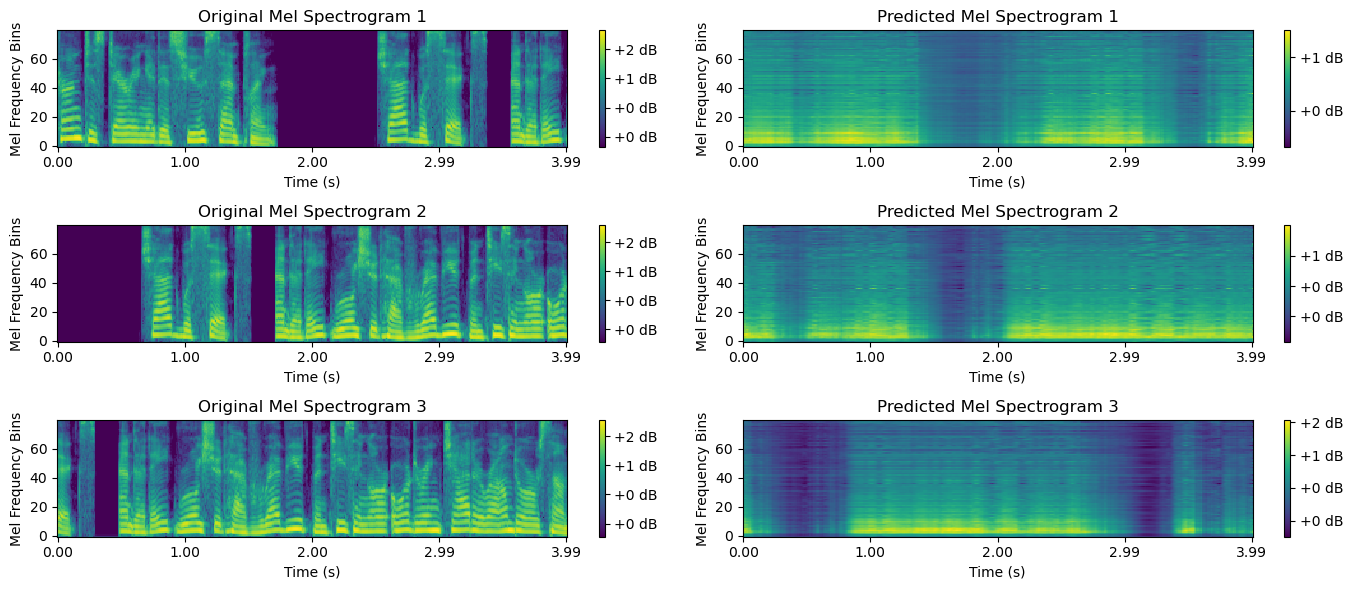

In [13]:
from utils.plot_mel import plot_mel_spectrogram

plot_mel_spectrogram(
    x=audio[15:18].cpu().numpy(),
    max_plots=3,
    x_pred=x[15:18].cpu().numpy(),
)

In [50]:
audio[17][:, 380:]

tensor([[-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        ...,
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237]],
       device='cuda:0')

In [48]:
audio.max(), audio.min(), audio.mean(), audio.std(), x.max(), x.min(), x.mean(), x.std()

(tensor(1.8948, device='cuda:0'),
 tensor(-0.2664, device='cuda:0'),
 tensor(0.4807, device='cuda:0'),
 tensor(0.4881, device='cuda:0'),
 tensor(3.1899, device='cuda:0'),
 tensor(-4.5614, device='cuda:0'),
 tensor(0.5055, device='cuda:0'),
 tensor(0.2960, device='cuda:0'))